# Fig 1. Version for paper

1a. % 0-9 y.o. in population

1a. nAHD from one of the obs datasets for WBGT28 

1b. horizontal histogram of total nHD and nAHD per latitude band (area-weighted avg) & % 0-9 y.o. in population

To finalize
- pick which stat model to use - DONE: loc only
- make sure i am using same present day year for all datasets : decide how to model covariates (do you used smooth or unsmoothed? and -GWI)
- update population data !! check accuracy with 2023 demographics - DONE

Extra stuff for SI
- all 3 obs datasets (SI)
- all models (SI) -> move out of here !
- maps + histograms


To do elsewhere: 
- eval model v. obs doing shift fit in both
- eval/stability of different time periods for shift fit in obs (?) or goodness of fit in another way - ask Clair

In [1]:
# necessary:  netcdf4-python, regionmask (automatically imports xarray), Cartopy, openpyxl, statsmodels

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches

%matplotlib inline

import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
import rasterio
from rasterio.features import geometry_mask
from scipy.stats import norm



In [2]:
from settings import *
from functions import * 
from plotscript import *

sys.path.append(os.path.join(os.environ['VSC_DATA_VO_USER'],'demographics4climate/'))
from population_demographics import * 

In [3]:
start_message()

flags: {'models': 'ISIMIP3a', 'experiment': 'obsclim', 'metric': 'WBGT', 'method': 'shift_fit', 'time_method': None, 'shift_sigma': True, 'shift_period': (1901, 2019), 'shift_loglike': None, 'chunk_version': 0, 'var': 'wbgt'}
var: wbgt
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0', 'EC-Earth3', 'UKESM1-0-LL', 'MPI-ESM1-2-HR', 'CNRM-ESM2-1']
datasets: ['GSWP3-W5E5', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_

In [4]:
# SETTINGS
figdir = os.path.join(figdirs, 'fig_sep24')

# geo information
landmask = get_mask()
cellarea = xr.open_dataarray(os.path.join(datadirs,'geo-information/clm45_area.nc4'))

dir_shift_fit = 'forster2024-hitol-nan'

## Fxns 



In [6]:
# for figure 1a 

def frac_per_country(
    da_countrymasks,
    df_countries_matched, 
    da_cohort_size,
    startyear=2023,
    endyear=2023,
    chunksize=100,
    age_slice=(0,9)
):
    """
    Calculate fraction of age_slice to total population in each country and output as a raster (DataArray) 
    based on isipedia binary countrymasks borders, for plotting. 
    """
    
    # Initialize the combined demographics DataArray
    da_out = None
    
    # Loop over countries in WCDE cohort sizes
    for country in da_cohort_size.country.values:    
        # Get iso3 code of the country in the mask 
        iso = df_countries_matched[df_countries_matched['country_wcde']==country]['iso3_frac'].values[0]
    
        # if this isocode is in the mask file 
        if iso in da_countrymasks['variable']: 
        
            # Get cohort sizes of the country
            da_smple_cht = da_cohort_size.sel(country=country).sel(time=slice(startyear, endyear)).chunk({'time': 10, 'ages': 10})
        
            # Cohort relative sizes in the sample country
            da_smple_cht_prp = da_smple_cht.sel(ages=slice(age_slice[0],age_slice[1] )).sum() / da_smple_cht.sum(dim='ages')

            # assign to grid cells based on countrymasks 
            frac_country = ( da_countrymasks.sel(variable=iso) * da_smple_cht_prp).drop_vars(['variable', 'country'])
        
            if da_out is None:
                da_out = frac_country
            else:
                da_out += frac_country
        
            # clear intermediate variables to free up memory
            del iso, da_smple_cht, da_smple_cht_prp
        else:
            pass
    
    da_out = da_out.compute()
    
    return da_out

In [7]:

# Define a function to format the x-ticks as percentages
def percent_formatter(x, pos):
    return f'{x:.0f}%'

In [8]:
def plot_barplot_mean_lat(da_p1_lat, 
                          da_nAHD_lat,
                          ax,
                          isel_cols = None,
                          title = ' \n \n',
                          plot_ylabels=True,
                          bar_width = 0.1,
                          second_legend=True,
                          legend_anchor = (1, 1.15),
                          xlabel='Days per year'
                          ): # could also do lat processing in here ! 
    
    df_nAHD = da_nAHD_lat.to_pandas().T
    df_p1 = da_p1_lat.to_pandas().T 

    if isel_cols:
        df_nAHD = df_nAHD.iloc[:,[isel_cols]]
        df_p1 = df_p1.iloc[:,[isel_cols]]
    
    # Settings
    bar_width = bar_width
    index = df_nAHD.index.astype(str)
    index = [s.replace('(', '').replace(']', '').replace(',', '°,') + '°' for s in index]
    cmap = matplotlib.colormaps['tab10'] #plt.cm.get_cmap('tab10')
    colors = [cmap(i) for i in np.linspace(0, 1, 10)]
    columns = df_nAHD.columns

    # Plot each model side by side
    for i, column in enumerate(columns):
        ax.barh(np.arange(0, len(index)) - (i-len(columns)//2) * bar_width, df_nAHD[column], bar_width, label=column,color=colors[i])
        ax.barh(np.arange(0,len(index)) - (i-len(columns)//2) * bar_width, df_p1[column], bar_width,  color=colors[i],alpha=0.4) 
    ax.set_ylim(0,7.6)
    ax.set_xlim(0,200)

        
    # Set labels and title
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    if plot_ylabels:
        ax.set_yticks(np.arange(0, len(index)))  # Set the y-tick positions
        ax.set_yticklabels(index, rotation=0)
    else:
        ax.set_yticks(np.arange(0, len(index))) 
        ax.set_yticklabels([])

    
    lgd = ax.legend(fontsize=9,frameon=False, loc='upper right',handlelength=1.2,handletextpad=0.4,bbox_to_anchor=legend_anchor)
    if second_legend:
        tot_patch = mpatches.Patch(color=colors[0], label='days$_{tot}$',alpha=0.4,edgecolor=None)
        attr_patch = mpatches.Patch(color=colors[0], label='days$_{attr}$')
        ax.legend(handles = [tot_patch, attr_patch ], fontsize=9,frameon=False, loc='lower right',handlelength=1.2,handletextpad=0.4,labelspacing = .1) 
        ax.add_artist(lgd)
        
    # Hide spines 
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)





In [9]:
def plot_map_nAHD(data_plot,
                    ax,
                    proj=ccrs.PlateCarree(),
                    vmin = -100,
                    vmax = 200, 
                    levels = np.linspace(-100, 200, 16),
                    title_label = None,
                  title=True
            ):

    cmap = LinearSegmentedColormap.from_list('new_RdBu_r', plt.get_cmap('RdBu_r')(np.linspace(0.25, 1, 192))) 
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    crs = ccrs.PlateCarree()
    ax.set_extent([-179.75, 179.75, -60, 90], crs=ccrs.PlateCarree())

    # plot
    plot = data_plot.plot(vmin=vmin, vmax=vmax, cmap=cmap, transform=crs, levels=levels, extend='both', add_colorbar=False, ax=ax)
    ax.coastlines(color='black', linewidth=0.8)
    if title:
        try: 
            ax.set_title(f'{data_plot.dataset.values}')
        except:
            ax.set_title(f'{data_plot.model.values}')
    else:
        ax.set_title('')
            
    ax.set_title(title_label, loc='left')

    return plot 

# 1a. % of 0-9 y.o 

Note that this is from WCDE projections ! Under ssp2 - can i update so its from real data?

In [10]:
df_cohort_sizes_ssp2, ages, years = load_cohort_sizes(ssp=2)
da_cohort_sizes = interpolate_cohortsize_countries(df_cohort_sizes_ssp2,
                                                 ages,
                                                 years)

interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 102, Libyan Arab Jamahiriya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero


In [11]:
# fraction of 0-9 yo in each country

da_nkids = da_cohort_sizes.sel(time=2023).sel(ages=slice(0,9)).sum(axis=1) 
da_npop =da_cohort_sizes.sel(time=2023).sum(dim='ages') 
df_fraction_kids = (da_nkids / da_npop).to_pandas()
df_fraction_kids.name = 'fraction_children'


In [12]:
da_npop.to_pandas() # * times 10^3 (unit: thousands of ppl)

country
Afghanistan              42474.50
Albania                   2834.76
Algeria                  44616.86
Angola                   35112.78
Antigua and Barbuda        105.00
                          ...    
Western Sahara             639.78
World                  7993284.68
Yemen                    32847.14
Zambia                   20488.30
Zimbabwe                 18513.68
Length: 202, dtype: float64

In [13]:
pd.DataFrame(df_fraction_kids).sort_values(by='fraction_children', ascending=False).head(20) 

,fraction_children
country,
Niger,0.347177
Uganda,0.325665
Somalia,0.314623
Chad,0.311744
Mali,0.311199
Zambia,0.305380
Democratic Republic of the Congo,0.304686
Malawi,0.302374
Burkina Faso,0.301099


In [14]:
da_countrymasks = load_countrymasks_binary() # load binary country mask
df_countries_matched = match_country_names_all_mask_frac(); # match country names between cohort sizes and fractional mask

Unmatched ISIMIP countries (without WCDE data) after all merges:
                   country           country_wb
194                Andorra              Andorra
196               Dominica             Dominica
199                  Palau                Palau
7            Liechtenstein        Liechtenstein
8         Marshall Islands     Marshall Islands
9                   Monaco               Monaco
10                   Nauru                Nauru
12   Saint Kitts and Nevis  St. Kitts and Nevis
13              San Marino           San Marino
14                  Tuvalu               Tuvalu
Unmatched WCDE countries after all merges:
                                   country_wcde
2                                         Aruba
3                               Channel Islands
4                                       Curaçao
5  Macao Special Administrative Region of China
6                                         World
Unmatched ISIMIP mask countries (geojson + frac mask) after all merges:
    

In [15]:
da_frac = frac_per_country(
    da_countrymasks,
    df_countries_matched, 
    da_cohort_sizes,
    startyear=2023,
    endyear=2023,
    chunksize=100,
    age_slice=(0,9)
)

In [16]:
da_frac.where(da_frac != 0 ).min()

<xarray.DataArray ()>
array(0.07781013)

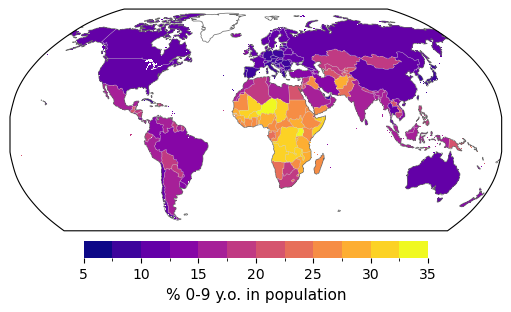

In [17]:
proj = ccrs.Robinson()
crs = ccrs.PlateCarree()


# create fig 
fig, ax = plt.subplots(figsize=(5,5),subplot_kw={'projection': proj},  layout='constrained') 

# setup
ax.set_extent([-181, 181, -63, 90], crs=ccrs.PlateCarree())
ax.coastlines(color='dimgray', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, facecolor="none", edgecolor='lightgray', linewidth=0.3 )

# plot
da_frac_children = da_frac.where(da_frac != 0 ).sel(time=2023)
plot = (da_frac_children *100).plot(add_colorbar=False, vmin=5,vmax=35, transform=crs, levels=13,cmap='plasma')
ax.set_title('')

#cbar
foo = ax.collections[0]
cbar = plt.colorbar(foo, ax=ax, location='bottom', shrink=0.7,pad=0.02)
cbar.set_label(label = '% 0-9 y.o. in population',size=11)

# set color params
cbar.ax.xaxis.set_tick_params(which='both')
cbar.outline.set_edgecolor('none')

# save
#plt.savefig(os.path.join(figdir,'fraction_09_discrete_trans3.png'),dpi=300,transparent=True)

## 1a. nAHD (WBGT28) in obs

To do:
- for paper do it only with one of the obs? add the horizontal hist and make a single figure together with demographics fig, put the other obs in SI
- fix colorbar limits
- do some regional/focus area analysis, worst hit areas etc.
- check covariate value for present and GWI value (GHG=1.45 or anthro=1.29?) - or real time online 1.304 (i think this is anthro)

Notes:
- very similar to ATTRICI obsclim v. counterclim (see isimip3a-wbgt-obsclim-counterclim), same patterns but larger numbers here, bc ref periods are also shifted, probably

In [18]:
# open data
flags['models']='ISIMIP3a'
dirname = 'output_shift-fit' 

da_list = []

for i in range(len(datasets)):
    dataset = datasets[i]
    filepath = glob.glob(os.path.join('/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output', 
                                      f'output_shift-fit/{dir_shift_fit}/WBGT/ISIMIP3a/{dataset}/*_obsclim_WBGT_params_shift_loc_mon_1901_2019.nc'))[0]
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [dataset]))
    da_list.append(da)
    
    da_params = xr.concat(da_list, dim="dataset")
    

In [19]:
df_gmst_obs_annual = pd.read_csv(os.path.join('../../data/gmst/gmst-obs/forster2024/annual_averages.csv')).rename(
    columns={'timebound_lower':'year'}).set_index('year')[['gmst']]
gmst_smo = pd.DataFrame(apply_lowess(df_gmst_obs_annual, df_gmst_obs_annual.index, ntime=4))
gmst_smo

,gmst
year,
1850,-0.050939
1851,0.034209
1852,0.071770
1853,0.067307
1854,0.058773
...,...
2019,1.210821
2020,1.209226
2021,1.160743


In [20]:
from scipy.stats import norm

threshold = 28

da_nAHD_obs, da_nAHD_mo, da_p0, da_p1 = calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2023,GWI=1.3)

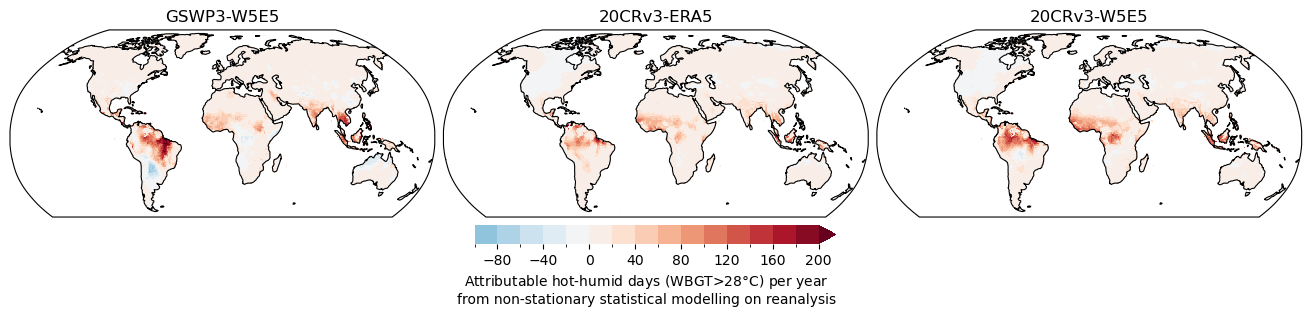

In [21]:

from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

# skewed colorbar ! 

# Create custom colormap
cmap = plt.get_cmap('RdBu_r')

# Extract the current RdBu_r colormap data
cmap_data = cmap(np.linspace(0, 1, 256))

# Define the new colormap that starts at -90 (roughly excludes first 6 shades of blue)
new_cmap_data = cmap_data[64:]  # This excludes the first quarter (64/256)
new_cmap = LinearSegmentedColormap.from_list('new_RdBu_r', new_cmap_data)

# Define the normalization boundaries
vmin, vmax = -100, 200
levels = np.linspace(vmin, vmax, 16)
norm = BoundaryNorm(levels, ncolors=new_cmap.N, clip=True)

proj = ccrs.Robinson()
crs = ccrs.PlateCarree()

# Make figure object
fig, axes = plt.subplots(1, 3, figsize=(13, 5), subplot_kw={'projection': proj}, layout='constrained')

for i in range(3):
    data_plot = da_nAHD_obs.isel(dataset=i) * landmask  # include or not landmask ?? 
    ax = axes[i]
    plot = plot_map_nAHD(data_plot, 
                  ax,
                 title=True)

cbar_lab = 'Attributable hot-humid days (WBGT>28$\degree$C) per year\nfrom non-stationary statistical modelling on reanalysis'
cbar = fig.colorbar(plot, extend='max', ax=axes, location='bottom', shrink=0.3, fraction=0.045, pad=0.02)
cbar.set_label(label=cbar_lab  )

# Set colorbar params
cbar.ax.xaxis.set_tick_params(which='both'  )
cbar.outline.set_edgecolor('none')



#plt.savefig(os.path.join(figdir,f'nAHD_isimip3a_all_skewcbar.png'),dpi=300)

In [22]:
print('min, max, mean (over land, not area-weighted)')

for i in range(3):
    data = da_nAHD_obs.isel(dataset=i) * landmask 
    print(data.min().values, data.max().values, data.mean().values)


min, max, mean (over land, not area-weighted)
-88.38899316463832 289.9744061757094 9.19715841990313
-15.083441447330005 221.50140154032442 6.882482146402155
-39.470813709731374 213.5021554995893 10.448494795778032


## Zonal area-weighted average bar plot : obs

Notes:
- obs generally agree on nAHD but don't agree on total n of days crossing threshold today? w5e5 is much more. But why is nAHD so similar then? And dont agree on baseline n of days crossing in pre-industrial
  
To define/finalize:
- giving each month equal weight (also in calc nAHD) - correct and use month length as weight? also use 30.4 
 
Extra:
+ add cities inset where super high (somewhere in India, somewhere in Indonesia, somewhere in S.America / Africa... Or in SI / conceptual figure ! with threshold and p1/p0 etc
+ make this lat bar fig also for models? 

In [23]:
# Define the latitudinal bands
lat_bins = range(-90, 91, 20)
[i for i in lat_bins]

[-90, -70, -50, -30, -10, 10, 30, 50, 70, 90]

In [24]:
# Group the data into the latitudinal bands and compute the mean for each band area weighted average per pixel 
# NB: giving each month equal weight in this! 

weighted_sum = (da_p0 * landmask * 30.4 * cellarea).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon','month'])
total_area = (cellarea * landmask).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon'])

da_p0_mean_lat = weighted_sum / total_area 
da_p0_mean_lat.to_pandas().T

dataset,GSWP3-W5E5,20CRv3-ERA5,20CRv3-W5E5
lat_bins,,,
"(-70, -50]",3.342774e-07,2.037708e-07,1.960274e-07
"(-50, -30]",3.242374e+00,1.416283e+00,2.474019e+00
"(-30, -10]",3.436507e+01,1.506169e+01,3.213198e+01
"(-10, 10]",7.286344e+01,1.027957e+01,6.451206e+01
"(10, 30]",4.049681e+01,2.680819e+01,4.244384e+01
"(30, 50]",4.897952e+00,3.762212e+00,5.280439e+00
"(50, 70]",5.898010e-02,6.656947e-02,7.845618e-02
"(70, 90]",8.029139e-03,2.199132e-03,9.122564e-03


In [25]:
weighted_sum = (da_p1 * landmask * 30.4 * cellarea).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon','month']) 
total_area = (cellarea * landmask).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon'])

da_p1_mean_lat = weighted_sum / total_area 
da_p1_mean_lat.to_pandas().T

dataset,GSWP3-W5E5,20CRv3-ERA5,20CRv3-W5E5
lat_bins,,,
"(-70, -50]",2.300584e-07,0.000002,0.000002
"(-50, -30]",3.045049e+00,2.387813,4.014960
"(-30, -10]",4.029867e+01,20.839394,38.403473
"(-10, 10]",1.138040e+02,40.252354,122.494417
"(10, 30]",6.540907e+01,45.730246,64.146311
"(30, 50]",7.191373e+00,4.769004,6.456582
"(50, 70]",1.390200e-01,0.103238,0.113953
"(70, 90]",1.445019e-02,0.002172,0.008705


In [26]:
weighted_sum = (da_nAHD_obs * landmask * cellarea).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon']) 
total_area = (cellarea * landmask).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon'])

da_nAHD_mean_lat = weighted_sum / total_area 
da_nAHD_mean_lat.to_pandas().T

dataset,GSWP3-W5E5,20CRv3-ERA5,20CRv3-W5E5
lat_bins,,,
"(-70, -50]",-1.010987e-07,0.000002,0.000002
"(-50, -30]",-1.843285e-01,0.963034,1.521729
"(-30, -10]",5.942410e+00,5.797379,6.277686
"(-10, 10]",4.101505e+01,29.988516,58.027874
"(10, 30]",2.503294e+01,19.039480,21.820252
"(30, 50]",2.321389e+00,1.016650,1.187984
"(50, 70]",8.040335e-02,0.036739,0.035531
"(70, 90]",6.504707e-03,-0.000031,-0.000395


Text(0, 0.5, 'Latitude')

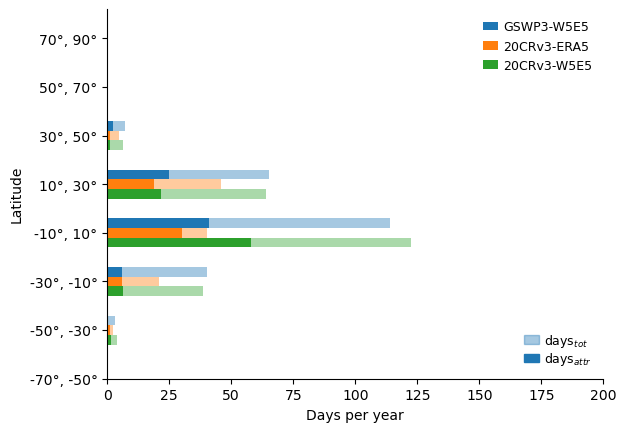

In [27]:

# Set up the figure and axis
fig, ax = plt.subplots()

plot_barplot_mean_lat(da_p1_mean_lat, 
                          da_nAHD_mean_lat,
                          ax=ax,
                          second_legend=True,
                            plot_ylabels=True,
                          bar_width = 0.2,
                      title=None,
                      legend_anchor = None
                      #xlabel='Hot-humid days (WBGT>28°C) per year'
                     )


# Set labels 
ax.set_ylabel('Latitude')


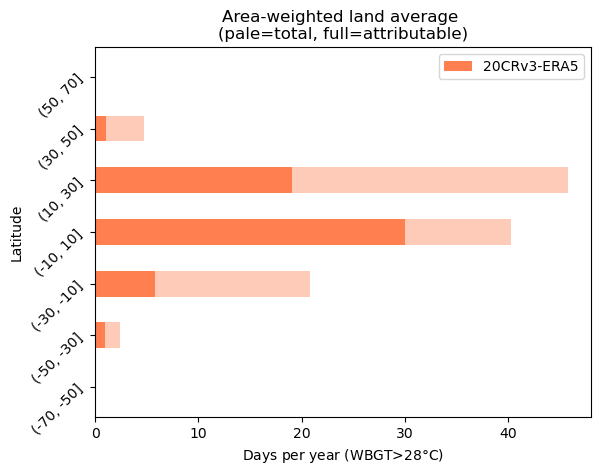

In [28]:

# Convert xarray DataArray to a pandas DataFrame and get rid of 70-90N
df_nAHD = pd.DataFrame(da_nAHD_mean_lat.to_pandas().T.iloc[:-1,1])
df_p1 = pd.DataFrame(da_p1_mean_lat.to_pandas().T.iloc[:-1,1])

# Get the list of column names
columns = df_p1.columns

# Set up the figure and axis
fig, ax = plt.subplots()

# Define width for each bar
bar_width = 0.5

# Define the index values for x-axis
index = df_p1.index.astype(str)

c='coral'

# Plot each column side by side
for i, column in enumerate(columns):
    ax.barh(np.arange(0,len(index)) + i * bar_width, df_p1[column], bar_width,  color=c,alpha=0.4) #label=column,
    ax.barh(np.arange(0,len(index)) + i * bar_width, df_nAHD[column], bar_width, label=column,color=c)

    
# Set labels and title
ax.set_ylabel('Latitude')
ax.set_xlabel('Days per year (WBGT>28$\degree$C)')
ax.set_title('Area-weighted land average \n(pale=total, full=attributable)')
plt.yticks(ticks=np.arange(0,len(index)), labels=index, rotation=45)
ax.legend()

# Show plot
plt.show()

## Per latitude %0-9 in population

In [29]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    gs_population_global = population_demographics_gridscale_global(
    startyear=2023,
    endyear=2023,
    ssp=2,
    )

loading country masks
interpolating cohort sizes per country
calculating gridscale demographics


In [30]:
gs_population_global

<xarray.DataArray (time: 1, lat: 360, lon: 720, ages: 105)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * time     (time) int64 2023
  * ages     (ages) int64 0 1 2 3 4 5 6 7 8 ... 96 97 98 99 100 101 102 103 104

In [31]:
nkids_lat = (gs_population_global.sel(ages=slice(0,9))).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon','ages'])
totpop_lat = gs_population_global.groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon','ages'])

#nkids_lat.to_pandas().T

In [32]:
totpop_lat.to_pandas().T.sum()

time
2023    8.008519e+09
dtype: float64

In [33]:
(nkids_lat/totpop_lat).to_pandas().T

time,2023
lat_bins,
"(-70, -50]",0.143254
"(-50, -30]",0.145429
"(-30, -10]",0.198633
"(-10, 10]",0.228284
"(10, 30]",0.168832
"(30, 50]",0.130741
"(50, 70]",0.110385
"(70, 90]",0.118328


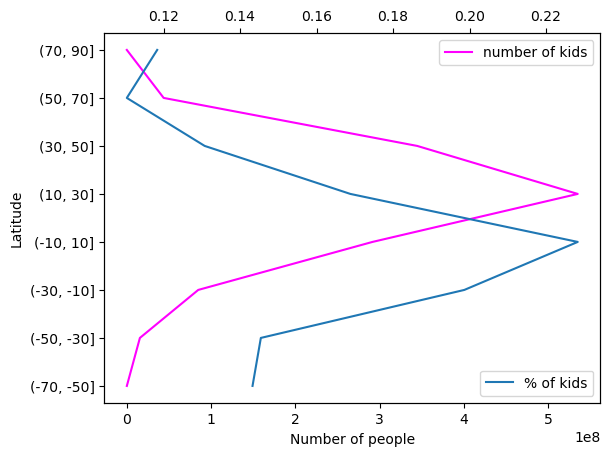

In [34]:
# Convert xarray DataArray to a pandas DataFrame and get rid of 70-90N
df_nkids = nkids_lat.to_pandas().T
df_frackids = (nkids_lat/totpop_lat).to_pandas().T

# Get the list of column names
column = df_nkids.columns[0]

# Set up the figure and axis
fig, ax = plt.subplots()

# Define width for each bar
bar_width = 0.5

# Define the index values for x-axis
index = df_nkids.index.astype(str)

c='magenta'

# Plot each column side by side
#ax.barh(np.arange(0,len(index)), df_nkids[column], bar_width, label='number of kids',color=c)
ax.plot(df_nkids[column],np.arange(0,len(index)),label='number of kids',color=c )
ax2 = ax.twiny()
ax2.plot(df_frackids[column],np.arange(0,len(index)),label='% of kids' )

# Set labels and title
ax.set_ylabel('Latitude')
ax.set_xlabel('Number of people')
plt.yticks(ticks=np.arange(0,len(index)), labels=index, rotation=45)
ax.legend()
ax2.legend(loc='lower right')

# Show plot
plt.show()

# Combine subplots

## v1 (20CRV3-ERA5)

This is on the lower end (see Fig 2) but "looks better" in the sense that there are less negatives
Bar plot has very different scale ! 

To do:
- decide if landmask or not in population plot

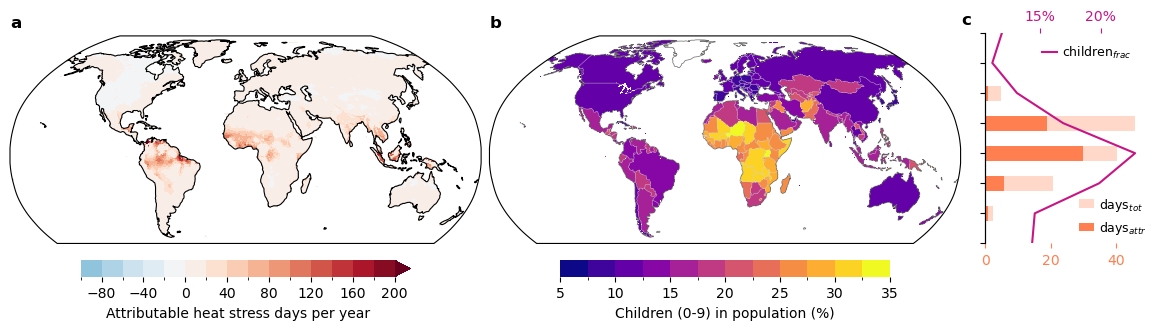

In [35]:

    
# settings 
proj = ccrs.Robinson()
dataset=1

# create figure layout
fig = plt.figure(figsize=(11.5, 3.2), layout='constrained')  
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 3, 1],figure=fig)  




# Subplot (a)  attributable days per year
# -----------------------------------
ax= fig.add_subplot(gs[0, 0], projection= proj)  
ax.set_extent([-179.75, 179.75, -60, 90], crs=ccrs.PlateCarree())



# setup
vmin, vmax = -100, 200 # min is -18 so could cut colorbar further !
levels = np.linspace(vmin, vmax, 16)
# plot 
data_plot = da_nAHD_obs.isel(dataset=dataset) * landmask
plot = data_plot.plot(transform=crs,ax=ax,vmax=vmax, vmin=vmin,add_colorbar=False,levels=levels,cmap=new_cmap,extend='both')
# appearance
ax.coastlines(color='black', linewidth=0.8)
ax.set_title('')
ax.set_title('a',loc='left',fontweight='bold')
# colorbar
cbar_lab = 'Attributable heat stress days per year'
cbar = fig.colorbar(plot, extend='max', ax=ax, location='bottom',shrink=0.7, fraction=0.1, pad=-.03)
cbar.set_label(label=cbar_lab,  )
cbar.ax.xaxis.set_tick_params(which='both',   )
cbar.outline.set_edgecolor('none')






# (b)  % children per country
# -----------------------------------
ax= fig.add_subplot(gs[0, 1], projection= proj)  
ax.set_extent([-179.75, 179.75, -60, 90], crs=ccrs.PlateCarree())

# plot
plot = (da_frac_children*100 * landmask).plot(add_colorbar=False, vmin=5,vmax=35, transform=crs, levels=13,cmap='plasma')

# appearance
ax.coastlines(color='dimgray', linewidth=0.5) # 
ax.add_feature(cfeature.BORDERS, facecolor="none", edgecolor='lightgray', linewidth=0.3 )
ax.set_title('')
ax.set_title('b',loc='left',fontweight='bold')

# colorbar
foo = ax.collections[0]
cbar = plt.colorbar(foo, ax=ax, location='bottom', shrink=0.7, fraction=0.1, pad=-.03)
cbar.set_label(label = 'Children (0-9) in population (%)', )
cbar.ax.xaxis.set_tick_params(which='both', )
cbar.outline.set_edgecolor('none')



# Subplot (c) latitude bands 
# -----------------------------------
ax= fig.add_subplot(gs[0, 2])  
ax.set_title('c ',loc='left',x=-0.15, y=1,fontweight='bold')

# 1. nAHD  
# -----------------------------------
df_nAHD = pd.DataFrame(da_nAHD_mean_lat.to_pandas().T.iloc[:,dataset])
df_p1 = pd.DataFrame(da_p1_mean_lat.to_pandas().T.iloc[:,dataset])
columns = df_p1.columns
index = df_p1.index.astype(str)
bar_width = 0.5
c='coral'
# Plot 
for i, column in enumerate(columns):
    ax.barh(np.arange(0,len(index)) + i * bar_width, df_p1[column], bar_width, color=c,alpha=0.3, label='days$_{tot}$') 
    ax.barh(np.arange(0,len(index)) + i * bar_width, df_nAHD[column], bar_width,color=c, label='days$_{attr}$') 


# 2. fraction kids
# -----------------------------------
df_frackids = (nkids_lat/totpop_lat * 100).to_pandas().T
column = df_nkids.columns[0]
c1='mediumvioletred'
ax2 = ax.twiny()
# Plot
ax2.plot(df_frackids[column],np.arange(0,len(index)),label='children$_{frac}$', color=c1 )

# Set labels
ax.set_yticks(ticks=np.arange(0,len(index)), labels='')
ax.set_ylim(0,7)
ax.legend(fontsize=9,frameon=False, loc='lower right',handlelength=1.2,handletextpad=0.4,bbox_to_anchor=(1.1, -0.02)) 
ax2.xaxis.set_major_formatter(FuncFormatter(percent_formatter))
ax2.legend(fontsize=9,frameon=False, loc='upper right',handlelength=1.2,handletextpad=0.4)

# Hide spines 
for spine in ['top', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)

# color the axes
ax2.spines['bottom'].set_color(c)
ax.tick_params(axis='x', colors=c)
ax.xaxis.label.set_color(c)
ax2.tick_params(axis='x', colors=c1)
ax2.xaxis.label.set_color(c1)

#plt.savefig(os.path.join(figdir,'fig1.pdf'),dpi=300,transparent=True)
#plt.savefig(os.path.join(figdir,'fig1.png'),dpi=300,transparent=True)

In [36]:
da_frac_children.min().values, da_frac_children.max().values

(array(0.07781013), array(0.3471771))

In [37]:
(da_nAHD_obs.isel(dataset=1) * landmask).min().values, (da_nAHD_obs.isel(dataset=1) * landmask).max().values

(array(-15.08344145), array(221.50140154))

## v2: (20CRV3-W5E5)

This gives the central estimate


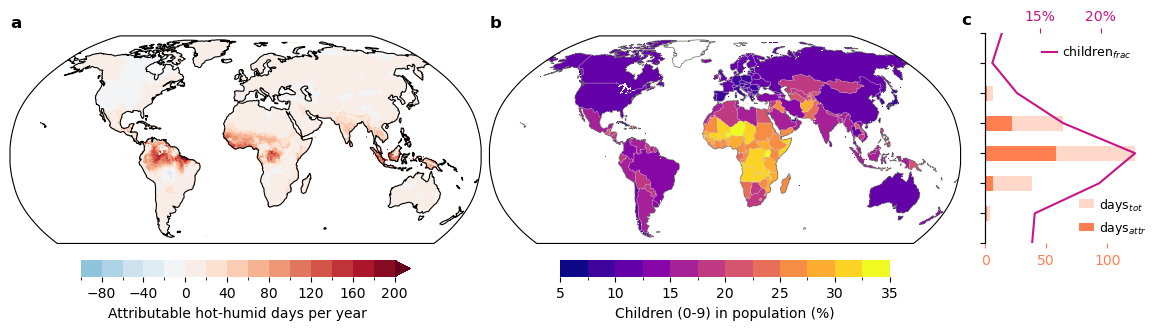

In [38]:

    
# settings 
proj = ccrs.Robinson()
dataset=2

# create figure layout
fig = plt.figure(figsize=(11.5, 3.2), layout='constrained')  
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 3, 1],figure=fig)  




# Subplot (a)  attributable days per year
# -----------------------------------
ax= fig.add_subplot(gs[0, 0], projection= proj)  
ax.set_extent([-179.75, 179.75, -60, 90], crs=ccrs.PlateCarree())



# setup
vmin, vmax = -100, 200 # min is -18 so could cut colorbar further !
levels = np.linspace(vmin, vmax, 16)
# plot 
data_plot = da_nAHD_obs.isel(dataset=dataset) * landmask
plot = data_plot.plot(transform=crs,ax=ax,vmax=vmax, vmin=vmin,add_colorbar=False,levels=levels,cmap=new_cmap,extend='both')
# appearance
ax.coastlines(color='black', linewidth=0.8)
ax.set_title('')
ax.set_title('a',loc='left',fontweight='bold')
# colorbar
cbar_lab = 'Attributable hot-humid days per year'
cbar = fig.colorbar(plot, extend='max', ax=ax, location='bottom',shrink=0.7, fraction=0.1, pad=-.03)
cbar.set_label(label=cbar_lab,  )
cbar.ax.xaxis.set_tick_params(which='both',   )
cbar.outline.set_edgecolor('none')






# (b)  % children per country
# -----------------------------------
ax= fig.add_subplot(gs[0, 1], projection= proj)  
ax.set_extent([-179.75, 179.75, -60, 90], crs=ccrs.PlateCarree())

# plot
plot = (da_frac_children*100 * landmask).plot(add_colorbar=False, vmin=5,vmax=35, transform=crs, levels=13,cmap='plasma')

# appearance
ax.coastlines(color='dimgray', linewidth=0.5) # 
ax.add_feature(cfeature.BORDERS, facecolor="none", edgecolor='lightgray', linewidth=0.3 )
ax.set_title('')
ax.set_title('b',loc='left',fontweight='bold')

# colorbar
foo = ax.collections[0]
cbar = plt.colorbar(foo, ax=ax, location='bottom', shrink=0.7, fraction=0.1, pad=-.03)
cbar.set_label(label = 'Children (0-9) in population (%)', )
cbar.ax.xaxis.set_tick_params(which='both', )
cbar.outline.set_edgecolor('none')



# Subplot (c) latitude bands 
# -----------------------------------
ax= fig.add_subplot(gs[0, 2])  
ax.set_title('c ',loc='left',x=-0.15, y=1,fontweight='bold')

# 1. nAHD  
# -----------------------------------
df_nAHD = pd.DataFrame(da_nAHD_mean_lat.to_pandas().T.iloc[:,dataset])
df_p1 = pd.DataFrame(da_p1_mean_lat.to_pandas().T.iloc[:,dataset])
columns = df_p1.columns
index = df_p1.index.astype(str)
bar_width = 0.5
c='coral'
# Plot 
for i, column in enumerate(columns):
    ax.barh(np.arange(0,len(index)) + i * bar_width, df_p1[column], bar_width, color=c,alpha=0.3, label='days$_{tot}$') 
    ax.barh(np.arange(0,len(index)) + i * bar_width, df_nAHD[column], bar_width,color=c, label='days$_{attr}$') 


# 2. fraction kids
# -----------------------------------
df_frackids = (nkids_lat/totpop_lat * 100).to_pandas().T
column = df_nkids.columns[0]
c1='mediumvioletred'
ax2 = ax.twiny()
# Plot
ax2.plot(df_frackids[column],np.arange(0,len(index)),label='children$_{frac}$', color=c1 )

# Set labels
ax.set_yticks(ticks=np.arange(0,len(index)), labels='')
ax.set_ylim(0,7)
ax.legend(fontsize=9,frameon=False, loc='lower right',handlelength=1.2,handletextpad=0.4,bbox_to_anchor=(1.1, -0.02)) #bbox_to_anchor=(1.05, 1.03)
ax2.xaxis.set_major_formatter(FuncFormatter(percent_formatter))
ax2.legend(fontsize=9,frameon=False, loc='upper right',handlelength=1.2,handletextpad=0.4)

# Hide spines 
for spine in ['top', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)

# color the axes
ax2.spines['bottom'].set_color(c)
ax.tick_params(axis='x', colors=c)
ax.xaxis.label.set_color(c)
ax2.tick_params(axis='x', colors=c1)
ax2.xaxis.label.set_color(c1)

# plt.savefig(os.path.join(figdir,'fig1_20crv3-w5e5.pdf'),dpi=300,transparent=True)
# plt.savefig(os.path.join(figdir,'fig1_20crv3-w5e5.png'),dpi=300,transparent=True)

## include lat labels

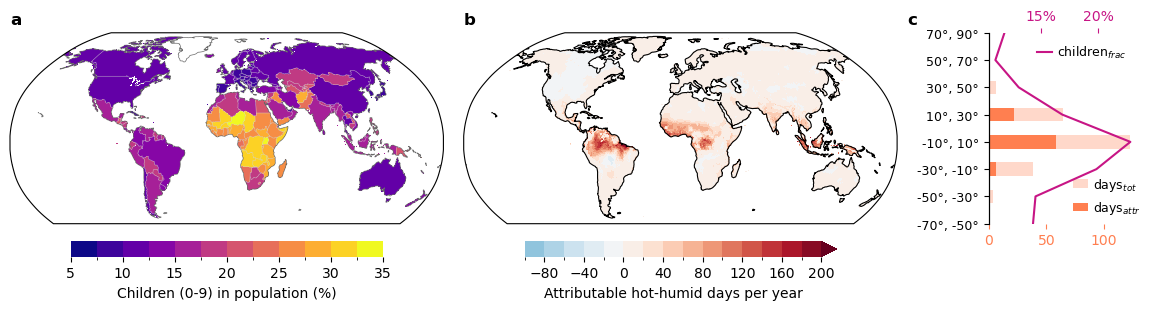

In [39]:

    
# settings 
proj = ccrs.Robinson()
dataset=2

# create figure layout
fig = plt.figure(figsize=(11.5, 3), layout='constrained')  
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 3, 1],figure=fig)  




# Subplot (a) % children per country
# -----------------------------------
ax= fig.add_subplot(gs[0, 0], projection= proj)  
ax.set_extent([-179.75, 179.75, -60, 90], crs=ccrs.PlateCarree())

# plot
plot = (da_frac_children*100 * landmask).plot(add_colorbar=False, vmin=5,vmax=35, transform=crs, levels=13,cmap='plasma')

# appearance
ax.coastlines(color='dimgray', linewidth=0.5) # 
ax.add_feature(cfeature.BORDERS, facecolor="none", edgecolor='lightgray', linewidth=0.3 )
ax.set_title('')
ax.set_title('a',loc='left',fontweight='bold')

# colorbar
#foo = ax.collections[0]
cbar = plt.colorbar(plot, ax=ax, location='bottom', shrink=0.7, fraction=0.1, pad=-.03)
cbar.set_label(label = 'Children (0-9) in population (%)', )
cbar.ax.xaxis.set_tick_params(which='both',  )
cbar.outline.set_edgecolor('none')



# (b) attributable days per year
# -----------------------------------
ax= fig.add_subplot(gs[0, 1], projection= proj)  

# plot 
data_plot = da_nAHD_obs.isel(dataset=dataset) * landmask
plot = plot_map_nAHD(data_plot, ax, title=False)
ax.set_title('b',loc='left',fontweight='bold')
#ax.gridlines(draw_labels=False)

# colorbar
cbar_lab = 'Attributable hot-humid days per year'
cbar = fig.colorbar(plot, extend='max', ax=ax, location='bottom',shrink=0.7, fraction=0.1, pad=-.03)
cbar.set_label(label=cbar_lab,  )
cbar.ax.xaxis.set_tick_params(which='both',  )
cbar.outline.set_edgecolor('none')



# Subplot (c) latitude bands 
# -----------------------------------
ax= fig.add_subplot(gs[0, 2])  
ax.set_title('c',loc='left',fontweight='bold',x=-0.55, y=1)

# 1. nAHD  
# -----------------------------------
df_nAHD = pd.DataFrame(da_nAHD_mean_lat.to_pandas().T.iloc[:,dataset])
df_p1 = pd.DataFrame(da_p1_mean_lat.to_pandas().T.iloc[:,dataset])
columns = df_p1.columns
index = df_p1.index.astype(str)
index = [s.replace('(', '').replace(']', '').replace(',', '°,') + '°' for s in index]
bar_width = 0.5
c='coral'
# Plot 
for i, column in enumerate(columns):
    ax.barh(np.arange(0,len(index)) + i * bar_width, df_p1[column], bar_width, color=c,alpha=0.3, label='days$_{tot}$') 
    ax.barh(np.arange(0,len(index)) + i * bar_width, df_nAHD[column], bar_width,color=c, label='days$_{attr}$') 


# 2. fraction kids
# -----------------------------------
df_frackids = (nkids_lat/totpop_lat * 100).to_pandas().T
column = df_nkids.columns[0]
c1='mediumvioletred'
ax2 = ax.twiny()
# Plot
ax2.plot(df_frackids[column],np.arange(0,len(index)),label='children$_{frac}$', color=c1 )

# Set labels
#ax.set_yticks(ticks=np.arange(0,len(index)), labels='')
ax.set_yticks(ticks=np.arange(0,len(index)), labels=index,fontsize=9)
ax.set_ylim(0,7)
ax.legend(fontsize=9,frameon=False, loc='lower right',handlelength=1.2,handletextpad=0.4,bbox_to_anchor=(1.1, -0.02)) #bbox_to_anchor=(1.05, 1.03)
ax2.xaxis.set_major_formatter(FuncFormatter(percent_formatter))
ax2.legend(fontsize=9,frameon=False, loc='upper right',handlelength=1.2,handletextpad=0.4)

# Hide spines 
for spine in ['top', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)

# color the axes
ax2.spines['bottom'].set_color(c)
ax.tick_params(axis='x', colors=c)
ax.xaxis.label.set_color(c)
ax2.tick_params(axis='x', colors=c1)
ax2.xaxis.label.set_color(c1)

#plt.savefig(os.path.join(figdir,'fig1_20crv3-w5e5_v2.pdf'),dpi=300,transparent=True)
#plt.savefig(os.path.join(figdir,'fig1_20crv3-w5e5_v2.png'),dpi=300,transparent=True)